In [1]:
!pip install pandas scikit-learn

In [2]:
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from include.utils import incrementar_dados_aleatorios_csv, categorizar_imc, dados_especificos_coluna
from include.graficos import montar_graficos, montar_grafico_correlacao
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

**1. Definição do Problema de Negócios**

**Contexto do Problema:**

O contexto do problema é a construção de um modelo preditivo de regressão para prever os custos médicos individuais cobrados pelo seguro de saúde.
Isso envolve analisar um conjunto de dados que contém informações sobre características individuais, como idade, gênero, IMC (índice de massa corporal), número de filhos, fumante ou não, região, entre outros, e os custos médicos correspondentes.

**Objetivos da Análise:**

- Desenvolver um modelo preditivo de regressão que possa fazer previsões confiáveis dos custos médicos individuais com base nas características fornecidas.
- Avaliar a importância das diferentes características no modelo de previsão de custos médicos.
- Identificar padrões e relacionamentos nos dados que possam ajudar a melhorar a precisão das previsões.
- Fornecer insights para ajudar a entender os principais fatores que influenciam os custos médicos individuais.

**Perguntas de Negócios:**

- Quais características individuais têm maior impacto nos custos médicos cobrados pelo seguro de saúde?
- Existe alguma correlação entre certas características (por exemplo, idade, IMC) e os custos médicos?
- O número de filhos influencia significativamente nos custos médicos?
- Há uma diferença significativa nos custos médicos entre fumantes e não fumantes?
- Qual é o impacto da região de residência no custo médico individual?
- Como o modelo pode ser utilizado para prever e planejar os custos médicos futuros?

**Benefícios Esperados:**

- Melhor compreensão dos fatores que contribuem para os custos médicos individuais.
- Desenvolvimento de um modelo preditivo preciso que possa ser usado para prever custos médicos futuros com base em diferentes características individuais.
- Melhoria na precificação do seguro de saúde, permitindo uma cobrança mais precisa e justa dos prêmios.
- Potencial economia de custos para seguradoras e segurados, evitando subestimação ou superestimação dos custos médicos.

**Descrição dos dados disponíveis**
    
Os dados disponíveis consistem em um conjunto de informações sobre segurados de um plano de saúde. Cada entrada no conjunto de dados contém as seguintes características:

- **Idade (int):** A idade do segurado.
- **Gênero (string):** O gênero do segurado (masculino ou feminino).
- **IMC (float):** O índice de massa corporal do segurado.
- **Número de Filhos (int):** O número de filhos do segurado.
- **Fumante (string):** Indicação se o segurado é fumante ou não.
- **Região (string):** A região geográfica onde o segurado reside.
- **Encargos (float):** Os custos médicos individuais cobrados pelo seguro de saúde.

Durante o processamento, os dados são salvos em 4 planilhas (pasta planilhas):
- **1_dados_originais.csv:** Esta planilha representa um "pequeno universo" de dados. No caso alimentei apenas com os dados mencionados no Tech Challenge do site da FIAP
- **2_dados_aleatorios_sobre_original.csv:** Esta planilha é gerada já no início do código para alimentar mais dados da planilha original, incrementar no dataset original, e além disso seus dados foram embaralhados, com colunas com dados nan (pra serem tratados mais a frente)
- **3_dados_com_outliers.csv:** Esta planilha demostra os outliers para cada coluna
- **4_dados_futuros.csv:** Esta planilha é gerada para realizar previsões futuras, após escolha do melhor modelo

Esses dados serão utilizados para desenvolver um modelo preditivo de regressão para prever os custos médicos individuais com base nas características fornecidas. Para alcançar esse objetivo, a avaliação dos modelos será realizada com base em métricas como R² (coeficiente de determinação) e MAE (erro absoluto médio) para medir a acurácia dos modelos. A seleção do melhor modelo será feita com base na acurácia média com validação cruzada, e a otimização de hiperparâmetros será direcionada para maximizar a acurácia do modelo selecionado.

**2. Análise dos Dados**

**Sumário dos Dados:**

In [3]:
# leia os dados CSV indicados no site da FIAP
dados = pd.read_csv('../planilhas/1_dados_originais.csv', encoding='latin-1')

# aqui chamo a função incrementar_dados_aleatorios, para aumentar o volume da variável dados
dados = incrementar_dados_aleatorios_csv(dados)

# Aplicar a função para categorizar IMC e criar uma nova coluna 'Categoria IMC'
dados['Categoria IMC'] = dados['IMC'].apply(categorizar_imc)

print("\nLista de todas colunas:\n\n", list(dados))
print("\nAmostra dos dados:\n\n", dados.head())
print(f"\nQuantidade de linhas: {dados.shape[0]}. Quantidade de colunas: {dados.shape[1]}")
print("\nTipos de dados das colunas:\n\n", dados.dtypes)
print("\nQuantidade de valores ausentes por coluna:\n\n", dados.isnull().sum())


Lista de todas colunas:

 ['Idade', 'Gênero', 'IMC', 'Filhos', 'Fumante', 'Região', 'Encargos', 'Categoria IMC']

Amostra dos dados:

    Idade     Gênero    IMC  Filhos Fumante    Região  Encargos Categoria IMC
0   56.0   feminino  29.77     2.0     sim  sudoeste  31109.89     Sobrepeso
1   46.0  masculino  25.86     1.0     não  nordeste  26650.70     Sobrepeso
2   32.0  masculino  23.01     0.0     não  sudoeste  21459.04   Peso normal
3   39.0   feminino  28.54     2.0     não   sudeste  29996.29     Sobrepeso
4   45.0  masculino  22.26     2.0     sim  noroeste  31594.72   Peso normal

Quantidade de linhas: 2003. Quantidade de colunas: 8

Tipos de dados das colunas:

 Idade            float64
Gênero            object
IMC              float64
Filhos           float64
Fumante           object
Região            object
Encargos         float64
Categoria IMC     object
dtype: object

Quantidade de valores ausentes por coluna:

 Idade            200
Gênero             0
IMC            

**Visualização dos Dados:** gráficos para entender a distribuição e padrões nos dados.

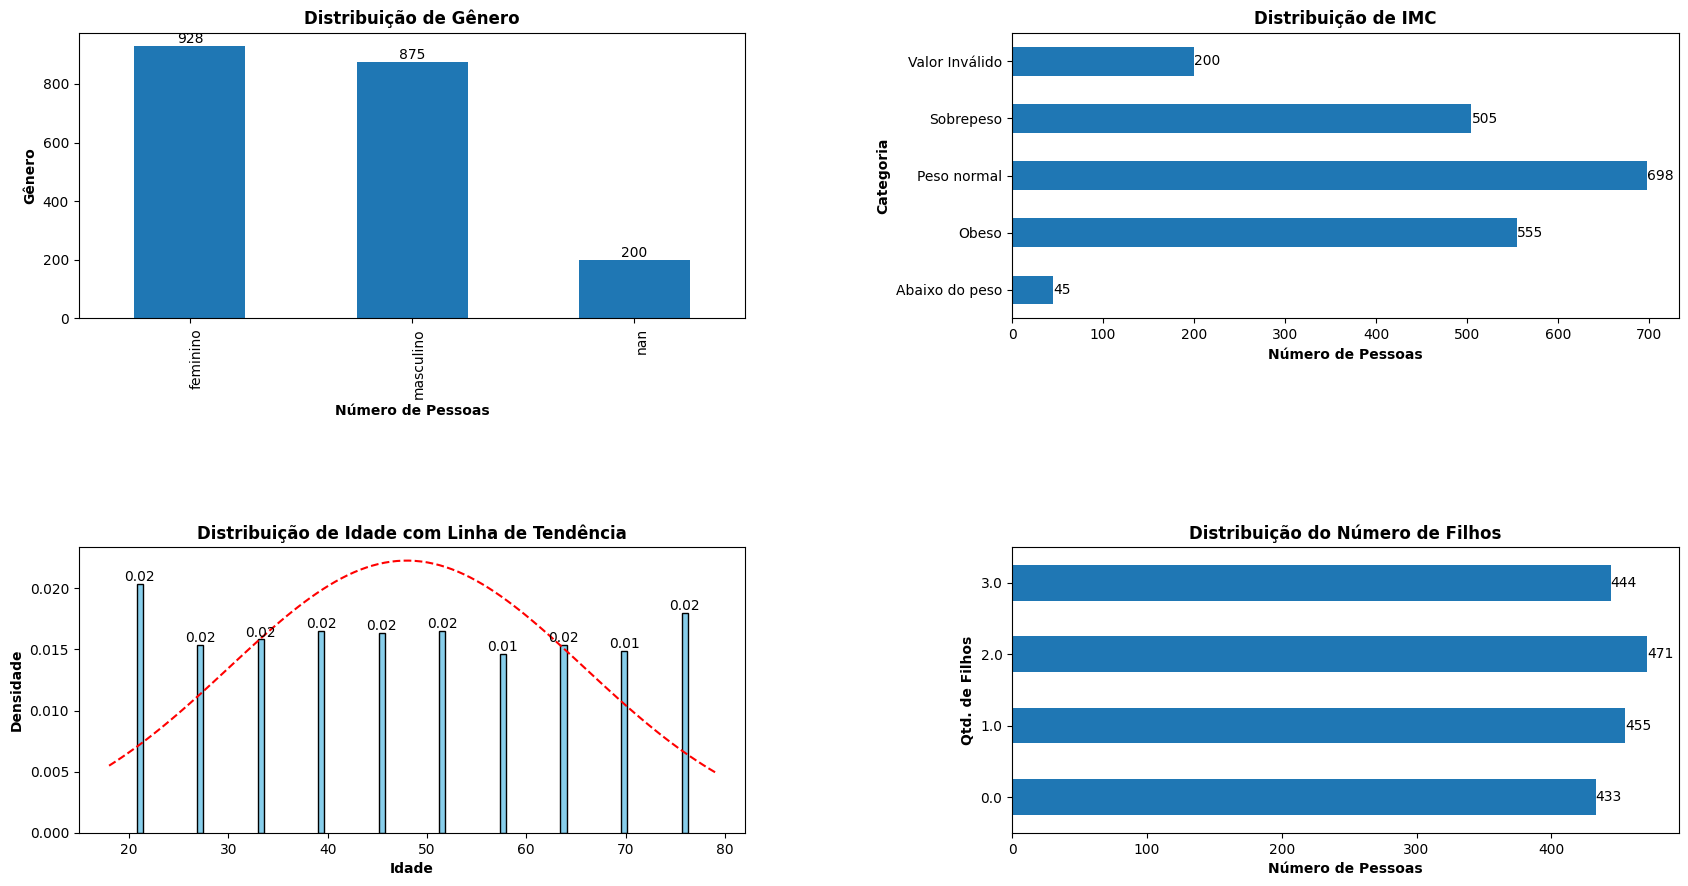

In [4]:
montar_graficos(dados)

**3. Separação dos Dados em Treino e Teste**

In [5]:
# Dividir os dados em features (X) e target (y)
X = dados.drop('Encargos', axis=1)  # descartando colunas não necessárias para o teste
y = dados['Encargos']

# Codificar variáveis categóricas usando one-hot encoding
encoder = OneHotEncoder(drop='first')
X_encoded = encoder.fit_transform(X[['Gênero', 'Região']])

# Concatenar features codificadas com as restantes
X_encoded = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(['Gênero', 'Região']), index=X.index)
X = pd.concat([X.drop(['Gênero', 'Região'], axis=1), X_encoded], axis=1)

# Codificar variável categórica 'IMC' com LabelEncoder
label_encoder = LabelEncoder()
X['Categoria IMC'] = label_encoder.fit_transform(X['Categoria IMC'])

# Substituir valores 'sim' e 'não' por 1 e 0
X['Fumante'] = X['Fumante'].map({'sim': 1, 'não': 0})

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

correlation_matrix = X_train.corr()
print('Visualizar a matriz de correlação:')
print(correlation_matrix)

Visualizar a matriz de correlação:
                     Idade       IMC    Filhos   Fumante  Categoria IMC  \
Idade             1.000000  0.015388 -0.018752  0.003656      -0.036374   
IMC               0.015388  1.000000 -0.052728 -0.019364      -0.294827   
Filhos           -0.018752 -0.052728  1.000000 -0.034858      -0.035247   
Fumante           0.003656 -0.019364 -0.034858  1.000000      -0.029452   
Categoria IMC    -0.036374 -0.294827 -0.035247 -0.029452       1.000000   
Gênero_masculino -0.000021  0.028709 -0.042726 -0.005567      -0.204174   
Gênero_nan             NaN       NaN       NaN       NaN       0.634922   
Região_nordeste   0.010237  0.011779  0.017922 -0.024127      -0.106595   
Região_noroeste  -0.030974 -0.025383 -0.020035  0.026131      -0.168399   
Região_sudeste    0.035535 -0.003682  0.017409  0.001770      -0.090517   
Região_sudoeste  -0.014540  0.016734 -0.015136 -0.003393      -0.101818   

                  Gênero_masculino  Gênero_nan  Região_nordeste 

**4. Análise Exploratória de Dados**

**Resumo Estatístico:**

In [6]:
print("\nInformações adicionais sobre os dados:\n\n", dados.describe())

dados_especificos_coluna(dados, "Idade")
dados_especificos_coluna(dados, "IMC")
dados_especificos_coluna(dados, "Filhos")
dados_especificos_coluna(dados, "Encargos")


Informações adicionais sobre os dados:

              Idade          IMC       Filhos      Encargos
count  1803.000000  1803.000000  1803.000000   1803.000000
mean     47.953966    26.533710     1.513588  30006.730599
std      17.912309     4.908871     1.106037   9295.061771
min      18.000000    18.010000     0.000000  11027.660000
25%      32.500000    22.270000     1.000000  22115.600000
50%      47.000000    26.280000     2.000000  29936.560000
75%      63.000000    30.860000     2.000000  37657.830000
max      79.000000    35.000000     3.000000  50356.990000

Na coluna Idade (float64) a faixa dos dados está entre: 18 até 79.
O valor mais frequente na coluna Idade é: 20, que aparece 41 vezes.

Na coluna IMC (float64) a faixa dos dados está entre: 18.01 até 35.0.
O valor mais frequente na coluna IMC é: 19.49, que aparece 6 vezes.

Na coluna Filhos (float64) a faixa dos dados está entre: 1 até 3.
O valor mais frequente na coluna Filhos é: 2, que aparece 471 vezes.

Na coluna Encar

<Axes: >

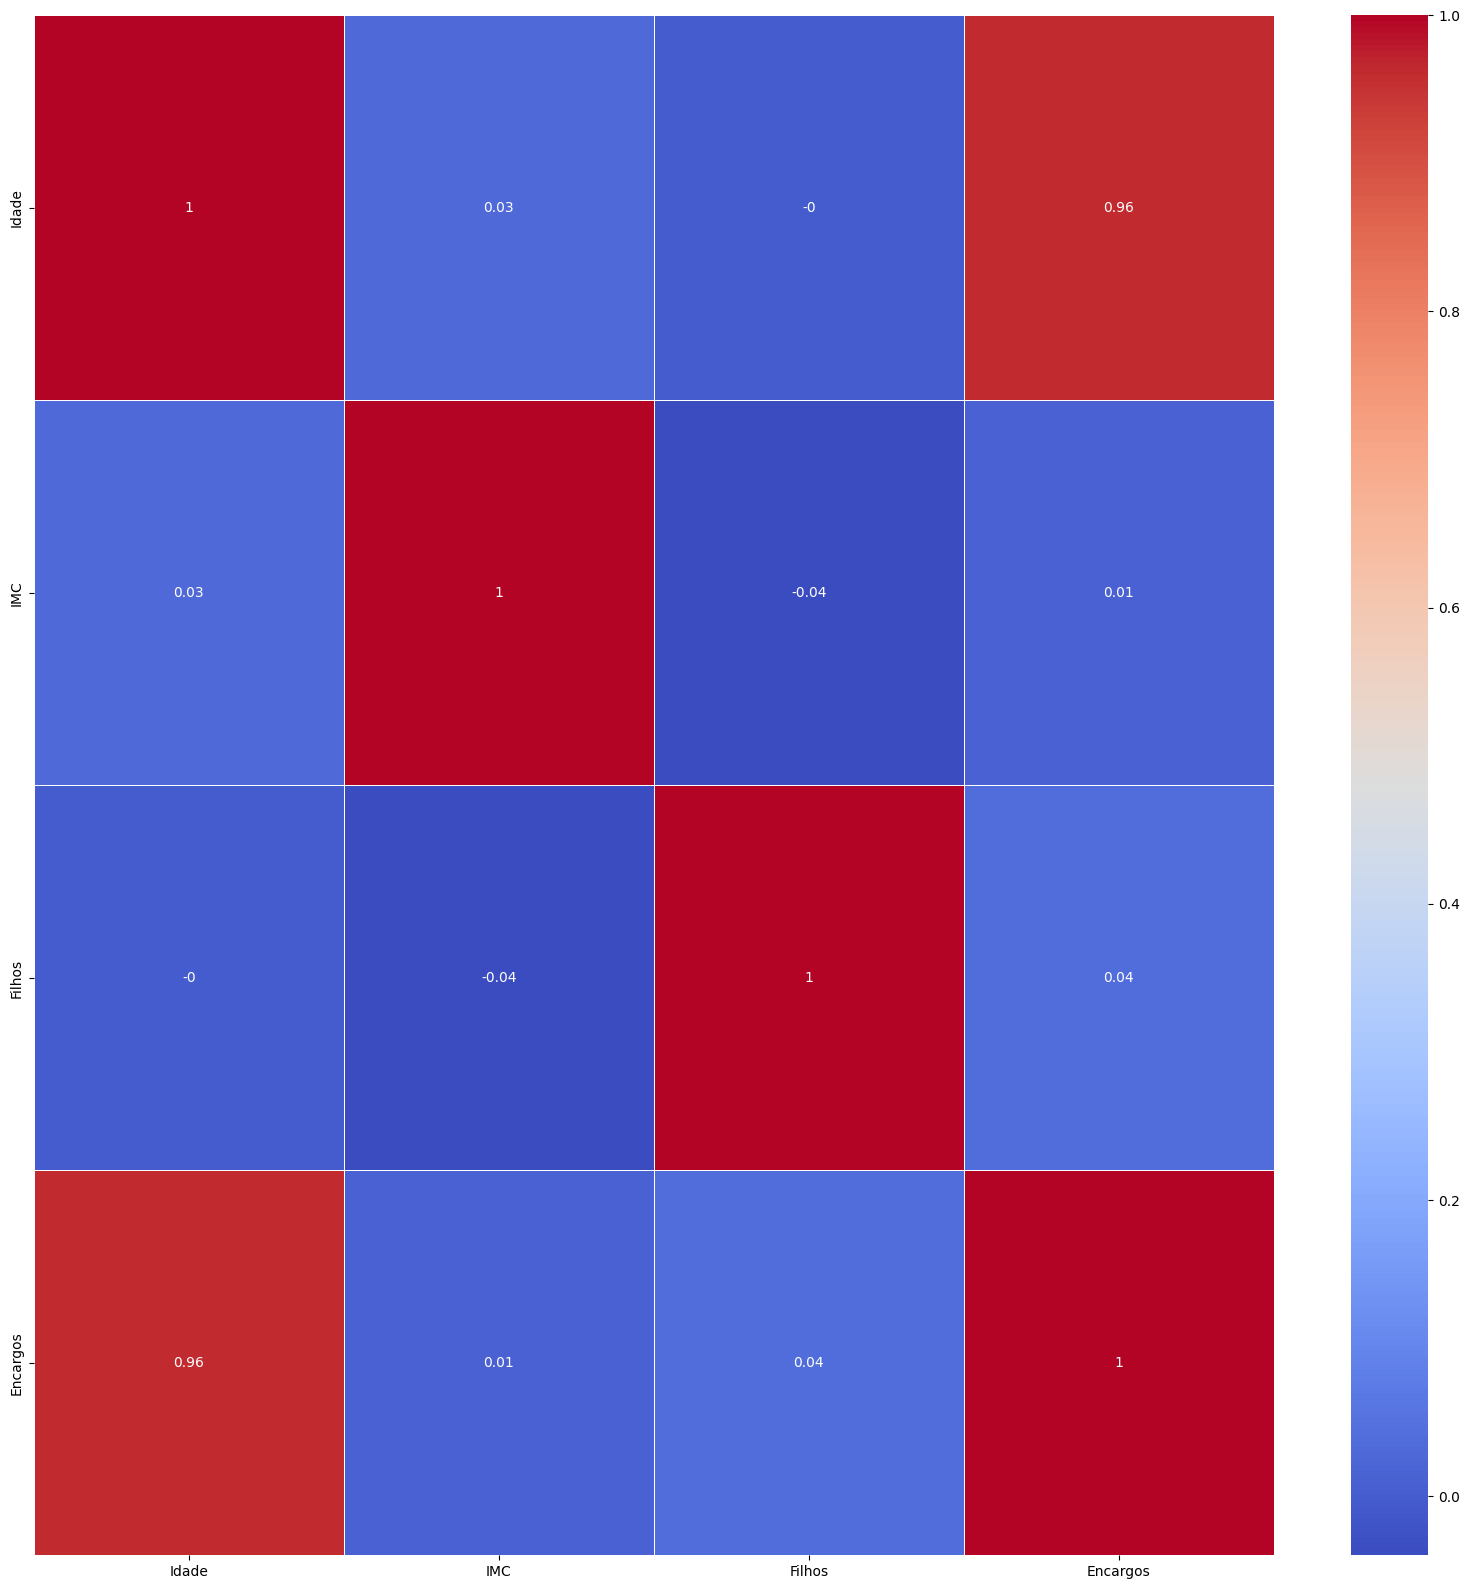

In [7]:
numeric_columns = dados.select_dtypes(include='number')

correlation_matrix = numeric_columns.corr().round(2)

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax, cmap="coolwarm")

**Identificação de Outliers:** 

In [8]:
for coluna in dados.columns:
    # quartis só funcionam em colunas numéricas
    if dados[coluna].dtype in ['int64', 'float64']:
        # Calcular os quartis para a coluna atual
        quartis = dados[coluna].quantile([0.25, 0.75])
        
        # Calcular o intervalo interquartil (IQR)
        iqr = quartis[0.75] - quartis[0.25]
        
        # Definir limites para identificar outliers
        limite_inferior = quartis[0.25] - 1.5 * iqr
        limite_superior = quartis[0.75] + 1.5 * iqr
        
        # Criar uma coluna de máscara para indicar outliers
        dados['outlier_mask_' + coluna] = ((dados[coluna] < limite_inferior) | (dados[coluna] > limite_superior)).astype(int)
        
        # Exibir os quartis e outliers
        print("Quartis para a coluna", coluna)
        print(quartis)
        print("Limite Inferior:", limite_inferior)
        print("Limite Superior:", limite_superior)
        print()

# Salvar os dados com os outliers
dados.to_csv("../planilhas/3_dados_com_outliers.csv", index=False, encoding='latin1')

Quartis para a coluna Idade
0.25    32.5
0.75    63.0
Name: Idade, dtype: float64
Limite Inferior: -13.25
Limite Superior: 108.75

Quartis para a coluna IMC
0.25    22.27
0.75    30.86
Name: IMC, dtype: float64
Limite Inferior: 9.385000000000009
Limite Superior: 43.74499999999999

Quartis para a coluna Filhos
0.25    1.0
0.75    2.0
Name: Filhos, dtype: float64
Limite Inferior: -0.5
Limite Superior: 3.5

Quartis para a coluna Encargos
0.25    22115.60
0.75    37657.83
Name: Encargos, dtype: float64
Limite Inferior: -1197.7450000000063
Limite Superior: 60971.175



**Visualizações Gráficas:** Visualizações gráficas para entender a distribuição e relacionamentos entre as variáveis

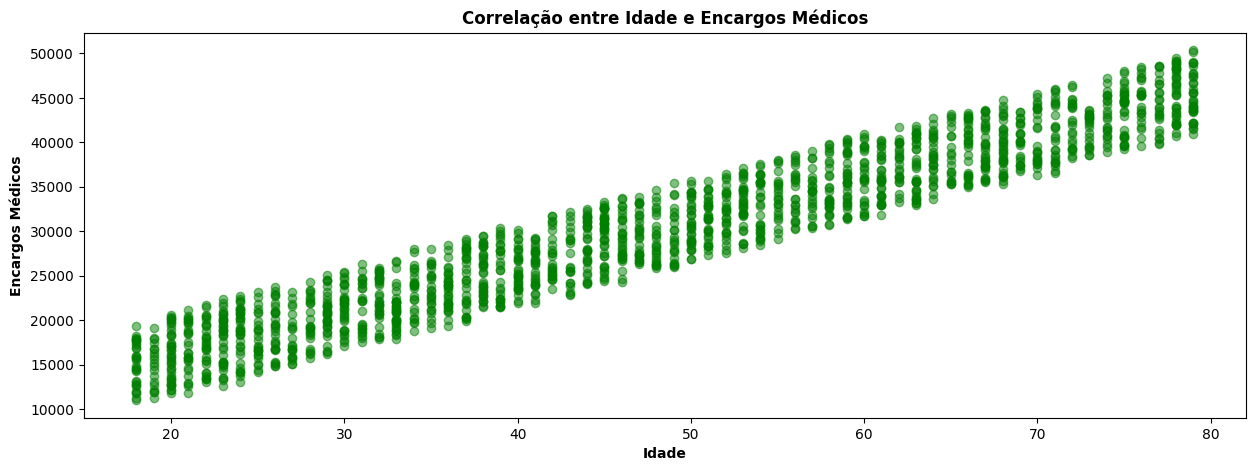

In [13]:
fig, axs = plt.subplots(figsize=(15, 5))

montar_grafico_correlacao(dados['Idade'], dados['Encargos'], axs,
                          'Correlação entre Idade e Encargos Médicos', 'Idade', 'Encargos Médicos')

plt.show()